## Project Data Wrangling - We rate dogs

Data wrangling project for Udacity's Data analyst course.

## Table of Contents
- [Gathering Data](#gather)
- [Assessing Data](#assess)
- [Cleaning Data](#clean)
- [Analyzing Data](#analyze)




In [3]:
import tweepy
import pandas as pd
import numpy as np
import requests
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
# use module dotenv to manage API keys and secrets
%load_ext dotenv
%dotenv

consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN')
access_secret = os.environ.get('ACCESS_SECRET')
tsv_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
tsv_filename = "image-predictions.tsv"
json_filename = "tweets_json.txt"


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


<a id='gather'></a>
### Gathering Data
We gather data from 3 several sources:
1. enhanced Twitter archive: a csv file 'twitter-archive-enhanced.csv' (data stored in `df_tweets_raw`)
2. Additional Data via the Twitter API
3. Image Predictions File by downloading a tsv file from a specific URL

##### 1.) Gathering Data: enhanced twitter archive
Let's start with getting the data from twitter archive file and take a look at a few records:


In [4]:
df_tweets_raw = pd.read_csv('twitter-archive-enhanced.csv')
df_tweets_raw.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
99,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,None,doggo,None,None,None
105,872122724285648897,NaN,NaN,2017-06-06 16:07:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kody. He's a baller. Wishes he was a l...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872122724...,12,10,Kody,None,None,None,None
1020,746757706116112384,NaN,NaN,2016-06-25 17:31:25 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Maddie. She gets some wicked air time....,NaN,NaN,NaN,https://vine.co/v/5BYq6hmrEI3,11,10,Maddie,None,None,None,None


##### 2.) Gathering Data: Additional data via twitter api
Get data via twitter api if not already downloaded and store it in file "tweets_json.txt":

In [5]:
if not (os.path.exists(json_filename)):
    # get tweets via api and store in json list:
    json_list = []
    i = 1
    for tweet_id in df_tweets_raw.tweet_id:
        try:
            #print progress:
            if (i % 100 == 0):
                print("tweets fetched: {}".format(i))
            i = i + 1
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json_list.append(tweet._json)
        except tweepy.TweepError as err:
            print("Error for tweet {}, error: {}".format(tweet_id, err))
            pass
            
    #store json list in json file:
    with open(json_filename, 'w') as f:
        for json_tweet in json_list:
            json.dump(json_tweet, f)
            f.write("\n")
    

In [6]:
#read json file into data frame and output a few lines
df_json_tweets= pd.read_json(json_filename, lines=True)
df_json_tweets.sample(3)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
1473,2016-01-28 02:12:04+00:00,692530551048294401,692530551048294400,Say hello to Cody. He's been to like 80 countr...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 692530544530296832, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1037,2016-06-11 01:13:51+00:00,741438259667034112,741438259667034112,This is Tucker. He's still figuring out couche...,False,"[0, 75]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 741438250968047616, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2219,2015-11-21 02:07:05+00:00,667886921285246976,667886921285246976,This is Erik. He's fucken massive. But also ki...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 667886917715943426, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


##### 3.) Gathering Data: Image Prediction file
Get file from internet if not already downloaded and show a few records

In [7]:
if not (os.path.exists(tsv_filename)):
    r = requests.get(tsv_url, allow_redirects=True)
    with open(tsv_filename, 'wb') as f:
            f.write(r.content)
df_img_pred = pd.read_csv(tsv_filename, sep="\t")
df_img_pred.head(10)
df_img_pred[df_img_pred.p1_dog == False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


<a id='assess'></a>
## Assessing Data

### 1.) Advanced Twitter Archive
**Quality:** 
- `name` column: some entries seem to be regular words rather than names (issue type: validity, visually explored)
- `rating_denominator` column: several entries are <> 10, indicating invalid rating values (issue type: validity, visually explored)
- `rating_numerator` column: several outliers with values > 20. Even if these ratings should be considered mostly humourous, these should be cleaned. (issue type: validity, viusally explored)
- `timestamp` column: data type is string, more appropriate format would be python's datetime format (issue type: validity, programmatically explored)
- several columns (`name`, `puppo`, etc.): NaN is string "None", more appropriate would be entry `np.nan`. (issue type: validity, visually explored)
- archive contains retweets and replies which should not be included in the analysis.
- `source` column: entries contain html information which should be stripped of the data.

**Tidiness:**
- columns `doggo`, `floofer`, `puppo` and `pupper` with mutual exclusive categorical data should be reduced to one column. 
- several columns are not being used in the analysis.

### 2.) Additional data Twitter API
**Quality:**
- additional data couldn't be fetched for all tweets from the archive (issue type: completeness)
- several columns are not being used in the analysis.

### 3.) Image prediction file
**Quality:**
- some tweets from the archive do not have a corresponding entry in the prediction file (issue type completeness)
- some predictions do not correctly assess the image's motif.

### Overall
**Tidiness:**
- Because of the 1:1:1 relationships between the records of the 3 tables, all data frames should be merged into a single table




<a id="clean"></a>
## Cleaning Data
### 1.) Twitter archive



In [8]:
#make copy to work with while cleaning the data
df_tweets_clean = df_tweets_raw.copy()

### Quality
##### Issue: Some names in the name column aren't actually names but regular words. 
##### Define
Issue is probably due to naive assumptions in parsing process of the tweet's text ("This is *dogname*"). So, my solution is to create
a new name column and extract only valid names from the name column. That is, only names with more than one letter starting with upper case.
##### Code

In [9]:
df_tweets_clean['name_extract']=''
df_tweets_clean['name_extract']= df_tweets_clean.name.str.extract(r"^([A-Z]\w+)")

##### Test

In [10]:
# check to see if only regluar words are left and haven't been extracted from the original name column
df_tweets_clean[df_tweets_clean.name_extract != df_tweets_clean.name]['name'].value_counts()

a               55
the              8
an               7
very             5
quite            4
just             4
one              4
getting          2
mad              2
not              2
actually         2
officially       1
incredibly       1
old              1
my               1
such             1
life             1
by               1
O                1
light            1
infuriating      1
this             1
his              1
unacceptable     1
space            1
all              1
Name: name, dtype: int64

In [11]:
# replace contents of name and drop temporary column name_extract and test again
df_tweets_clean.name = df_tweets_clean.name_extract
df_tweets_clean.drop('name_extract', axis=1, inplace = True)
df_tweets_clean.name.value_counts()

None       745
Charlie     12
Oliver      11
Cooper      11
Lucy        11
          ... 
Lorelei      1
Fynn         1
Tino         1
Godi         1
Shikha       1
Name: name, Length: 931, dtype: int64

##### Issue: `rating_denominator` column: several entries are <> 10, indicating invalid rating values.
##### Define
We are making the very rigourous assumption that only ratings with denominator = 10 are valid ratings. So, we delete all rows with denominators <> 10.
##### Code

In [12]:
invalid_ratings = df_tweets_clean[df_tweets_clean.rating_denominator != 10].index
df_tweets_clean.drop(invalid_ratings, inplace =True)

##### Test

In [13]:
# value counts should only show entries for value 10
df_tweets_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

##### Issue: `rating_numerator` column: several entries are values > 20, indicating invalid rating values.
##### Define
We are making the very rigourous assumption that only ratings with numerator <= 20 are valid ratings. So, we delete all rows with denominators <> 10.
##### Code

In [14]:
invalid_numerators = df_tweets_clean[df_tweets_clean.rating_numerator > 20].index
df_tweets_clean.drop(invalid_numerators, inplace=True)

##### Test

In [15]:
# value counts should only show entries with value <= 20
df_tweets_clean.rating_numerator.value_counts()

12    558
11    463
10    461
13    351
9     156
8     102
7      54
14     54
5      37
6      32
3      19
4      15
2       9
1       8
0       2
15      2
17      1
Name: rating_numerator, dtype: int64

##### Issue: `timestamp` column: data type is string
##### Define
convert datatype of `timestamp` to datetime
##### Code

In [16]:
df_tweets_clean.timestamp = pd.to_datetime(df_tweets_clean.timestamp)

##### Test

In [17]:
df_tweets_clean.timestamp.head(3)

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

##### Issue: several columns (`name`, `puppo`, etc.): NaN is string "None", more appropriate would be entry `np.nan`.
##### Define
convert string value "None" to `np.nan`
##### Code

In [18]:
df_tweets_clean.replace(r'None', np.nan, inplace=True)

##### Test

In [19]:
df_tweets_clean.isna()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,False,True,True,False,False,False,True,True,True,False,False,False,False,True,True,True,True
1,False,True,True,False,False,False,True,True,True,False,False,False,False,True,True,True,True
2,False,True,True,False,False,False,True,True,True,False,False,False,False,True,True,True,True
3,False,True,True,False,False,False,True,True,True,False,False,False,False,True,True,True,True
4,False,True,True,False,False,False,True,True,True,False,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,False,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True
2352,False,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True
2353,False,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True
2354,False,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,True


##### Issue: archive contains retweets and replies which should not be included in the analysis.
##### Define
Only keep rows with `retweeted_status_id` = NaN and `in_reply_to_status_id` = NaN
##### Code

In [20]:
df_tweets_clean = df_tweets_clean[(df_tweets_clean.retweeted_status_id.isna()) & (df_tweets_clean.in_reply_to_status_id.isna())]

##### Test

In [21]:
# are replies left?
df_tweets_clean.in_reply_to_status_id.notna().sum()

0

In [22]:
# are retweets left?
df_tweets_clean.retweeted_status_id.notna().sum()

0

##### Issue: `source` column: entries contain html information which should be stripped of the data.
##### Define
Use the regex mode in `replace` to extract the relevant information from the string.
##### Code

In [23]:
df_tweets_clean.source = df_tweets_clean.loc[:, 'source'].replace(r"<.*>([\w -]+)</a>", r"\1", regex= True)

##### Test

In [24]:
df_tweets_clean.source.value_counts()

Twitter for iPhone     1943
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### Tidiness

##### Issue: columns `doggo`, `floofer`, `puppo` and `pupper` with mutual exclusive categorical data should be reduced to one column.
##### Define
create new column `stage` and fill it with a little string operation trick by first replacing the NaNs in the 4 stages columns with "",
and then concatenating the 4 strings and putting the result in the new column. Entries with "" should be replaced by `np.nan` then.
##### Code

In [25]:
df_tweets_clean[['doggo', 'floofer', 'puppo', 'pupper']] = df_tweets_clean[['doggo', 'floofer', 'puppo', 'pupper']].fillna("")
df_tweets_clean['stage'] = '' +  df_tweets_clean.doggo + df_tweets_clean.floofer + df_tweets_clean.puppo + df_tweets_clean.pupper
df_tweets_clean['stage'] = df_tweets_clean['stage'].replace("", np.nan)

##### Test

In [26]:
df_tweets_clean['stage'].value_counts()

pupper          220
doggo            72
puppo            23
doggopupper       9
floofer           9
doggofloofer      1
doggopuppo        1
Name: stage, dtype: int64

In [27]:
# Test output above shows invalid double categorization, we have to clean this as well:
df_tweets_clean['stage'] = df_tweets_clean['stage'].replace(r"doggo\w+", np.nan, regex=True)
df_tweets_clean['stage'].value_counts()

pupper     220
doggo       72
puppo       23
floofer      9
Name: stage, dtype: int64

##### Issue: several columns are not being used in the analysis.
##### Define
Only keep rows which are used in the analysis or for later merging the data with other tables.
##### Code

In [28]:
df_tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'stage'],
      dtype='object')

In [29]:
df_tweets_clean = df_tweets_clean.loc[:,['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'stage']]
df_tweets_clean.dtypes

tweet_id                            int64
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
stage                              object
dtype: object

### 2.) Additional data Twitter API

In [30]:
#make copy to work with while cleaning the data
df_json_clean = df_json_tweets.copy()

##### Issues: several columns are not being used in the analysis.
##### Define
Only keep rows which are used in the analysis or for later merging the data with other tables.
##### Code

In [31]:
df_json_clean = df_json_clean.loc[:,['id','favorite_count', 'retweet_count']]

##### Test

In [32]:
df_json_clean

,id,favorite_count,retweet_count
0,892420643555336193,36780,7842
1,892177421306343426,31671,5805
2,891815181378084864,23853,3845
3,891689557279858688,40109,8010
4,891327558926688256,38310,8651
...,...,...,...
2326,666049248165822465,99,41
2327,666044226329800704,279,134
2328,666033412701032449,117,43
2329,666029285002620928,121,43


##### Issue: additional data couldn't be fetched for all tweets from the archive
##### Define
Since the tweet has probably been deleted from twitter it's not possible to add the missing tweet information. So,
we will drop the incomplete data from the archive instead.
##### Code

In [33]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.tweet_id.isin(list(df_json_clean.id))]

##### Test

In [34]:
# is any missing data left?
df_tweets_clean[~(df_tweets_clean.tweet_id.isin(list(df_json_clean.id)))]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage


### 3.) Image Prediction File

In [35]:
#make copy to work with while cleaning the data
df_img_clean = df_img_pred.copy()

##### Issue: several columns are not being used in the analysis.
##### Define
Only keep rows which are used in the analysis or for later merging the data with other tables.
##### Code

In [36]:
df_img_clean = df_img_clean.loc[:, ['tweet_id', 'jpg_url', 'p1', 'p1_conf', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]

##### Test

In [37]:
df_img_clean

,tweet_id,jpg_url,p1,p1_conf,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


##### Issue: image predictions are not available for all tweets from the archive
##### Define
It's not possible to add the missing tweet information. So,
we will drop the incomplete data from the archive instead.
##### Code

In [38]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.tweet_id.isin(list(df_img_clean.tweet_id))]

In [39]:
df_tweets_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN


### Overall
##### Issue: 3 tables should be joined into 1 table
##### Define
Use pandas function `merge` to join the tables with the twitter id as key
##### Code

In [40]:
# make one merge after another, first join the json df to the archive and then add the prediction data
df_complete = pd.DataFrame()
df_complete = df_tweets_clean.merge(df_json_clean, left_on='tweet_id', right_on='id')
df_complete = df_complete.merge(df_img_pred, left_on='tweet_id', right_on='tweet_id')

##### Test

In [41]:
df_complete.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'id',
       'favorite_count', 'retweet_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

In [42]:
# now we have some redundant twitter id colmns, so, we get rid of them:
df_complete.drop(columns=['id'])
df_complete.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
481,789137962068021249,2016-10-20 16:15:26+00:00,Twitter for iPhone,This is Bo. He's a West Congolese Bugaboop Snu...,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,NaN,789137962068021249,...,2,Chihuahua,0.746135,True,Pekinese,0.070383,True,Pembroke,0.049237,True
447,793845145112371200,2016-11-02 16:00:06+00:00,Twitter for iPhone,This is Clark. He was just caught wearing pant...,https://twitter.com/dog_rates/status/793845145...,13,10,Clark,NaN,793845145112371200,...,1,Old_English_sheepdog,0.765277,True,Bedlington_terrier,0.112753,True,Kerry_blue_terrier,0.047662,True
1907,666430724426358785,2015-11-17 01:40:41+00:00,Twitter for iPhone,Oh boy what a pup! Sunglasses take this one to...,https://twitter.com/dog_rates/status/666430724...,6,10,NaN,NaN,666430724426358785,...,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False


In [43]:
### output cleaned file to csv
df_complete.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
### Analyzing Data


In [44]:
# first loading the data from the clean masterfile
df_archive_master = pd.read_csv('twitter_archive_master.csv')
df_archive_master.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1364,679148763231985668,2015-12-22 03:57:37+00:00,Twitter for iPhone,I know everyone's excited for Christmas but th...,https://twitter.com/dog_rates/status/679148763...,8,10,NaN,NaN,679148763231985668,...,1,Italian_greyhound,0.302685,True,hair_slide,0.124281,False,Afghan_hound,0.059846,True
771,742150209887731712,2016-06-13 00:22:53+00:00,Twitter for iPhone,This is Edmund. He sends stellar selfies. Cute...,https://twitter.com/dog_rates/status/742150209...,8,10,Edmund,pupper,742150209887731712,...,1,Siamese_cat,0.112413,False,French_bulldog,0.071414,True,hog,0.062465,False
1559,673350198937153538,2015-12-06 03:56:12+00:00,Twitter for iPhone,This is Bella. She's a Genghis Flopped Canuck....,https://twitter.com/dog_rates/status/673350198...,9,10,Bella,NaN,673350198937153538,...,1,West_Highland_white_terrier,0.119188,True,quill,0.104014,False,Maltese_dog,0.093944,True


### 1.) What are the most tweeted dog breeds?
According to the image predictions, which dog breeds are the most frequent motifs in the photographs?

In [45]:
top_breeds = df_archive_master.p1.value_counts().head(10)
top_breeds

golden_retriever      134
Pembroke               88
Labrador_retriever     88
Chihuahua              78
pug                    54
chow                   41
Samoyed                39
Pomeranian             37
toy_poodle             36
malamute               29
Name: p1, dtype: int64

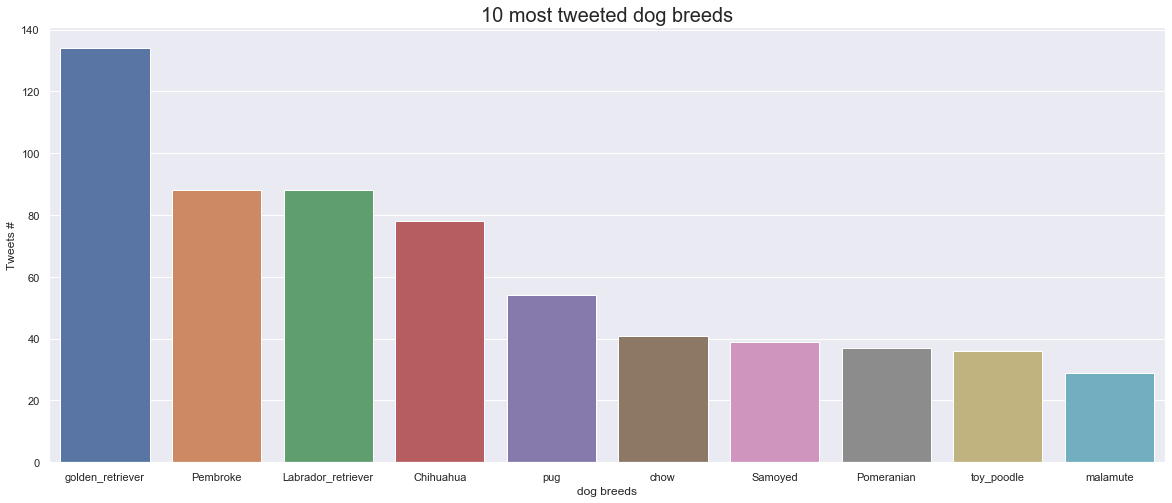

In [46]:
# visualization
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.barplot(top_breeds.index, top_breeds.values, label='Top 10 breeds on images')
ax.set_title('10 most tweeted dog breeds', fontsize=20)
ax.set_xlabel('dog breeds')
ax.set_ylabel('Tweets #')
fig.savefig('img/topbreeds.jpg')

### 2.) Which dog breeds are liked most frequently?
In terms of favorite counts, the tweets about which dog breeds are liked most frequently?

In [47]:
# first group the favorite counts and ratings by dog breeds and calculate mean and sum
df_breed_fav = df_archive_master[df_archive_master.p1_dog == True].groupby('p1').agg({'favorite_count':['mean', 'sum'], 'rating_numerator':'mean'}).reset_index()
df_breed_fav

p1 favorite_count         rating_numerator
                                              mean     sum             mean
0                      Afghan_hound   16029.666667   48089         9.666667
1                          Airedale    4899.166667   58790         9.833333
2    American_Staffordshire_terrier    5795.083333   69541        10.833333
3                       Appenzeller    6798.000000   13596        11.000000
4                Australian_terrier   10346.500000   20693        11.500000
..                              ...            ...     ...              ...
105                      toy_poodle    6108.805556  219917        11.027778
106                     toy_terrier    4178.000000    8356        11.000000
107                          vizsla    6956.384615   90433        10.846154
108                         whippet    8090.555556   72815        10.444444
109         wire-haired_fox_terrier    7900.500000   15801        11.500000

[110 rows x 4 columns]

In [48]:
# obtain the 10 dog breeds with the hightest sum of likes
top10_breed_fav_total = df_breed_fav.sort_values(by=('favorite_count', 'sum'), ascending=False).head(10)
top10_breed_fav_total

p1 favorite_count          rating_numerator
                                 mean      sum             mean
86    golden_retriever   11629.820896  1558396        11.567164
35  Labrador_retriever   11232.965909   988501        11.102273
47            Pembroke   10721.920455   943529        11.443182
15           Chihuahua    8354.705128   651667        10.692308
53             Samoyed   12497.487179   487402        11.743590
22      French_bulldog   17752.920000   443823        11.240000
79                chow    9408.317073   385741        11.609756
98                 pug    5493.759259   296663        10.240741
80      cocker_spaniel   10853.925926   293056        11.296296
48          Pomeranian    7279.648649   269347        11.189189

In [49]:
# obtain the 10 dog breeds with the hightest average of likes
top10_breed_fav_mean= df_breed_fav.sort_values(by=('favorite_count', 'mean'), ascending=False).head(10)
top10_breed_fav_mean


p1 favorite_count         rating_numerator
                                       mean     sum             mean
52                    Saluki   22539.500000   90158        12.500000
22            French_bulldog   17752.920000  443823        11.240000
0               Afghan_hound   16029.666667   48089         9.666667
85           giant_schnauzer   16028.000000   32056        11.500000
71   black-and-tan_coonhound   15880.000000   31760        10.500000
84     flat-coated_retriever   15692.875000  125543        10.875000
32       Irish_water_spaniel   15213.000000   45639        11.333333
103          standard_poodle   14785.857143  103501        10.285714
19          English_springer   14603.777778  131434        11.111111
13                  Cardigan   14211.294118  241592        11.529412

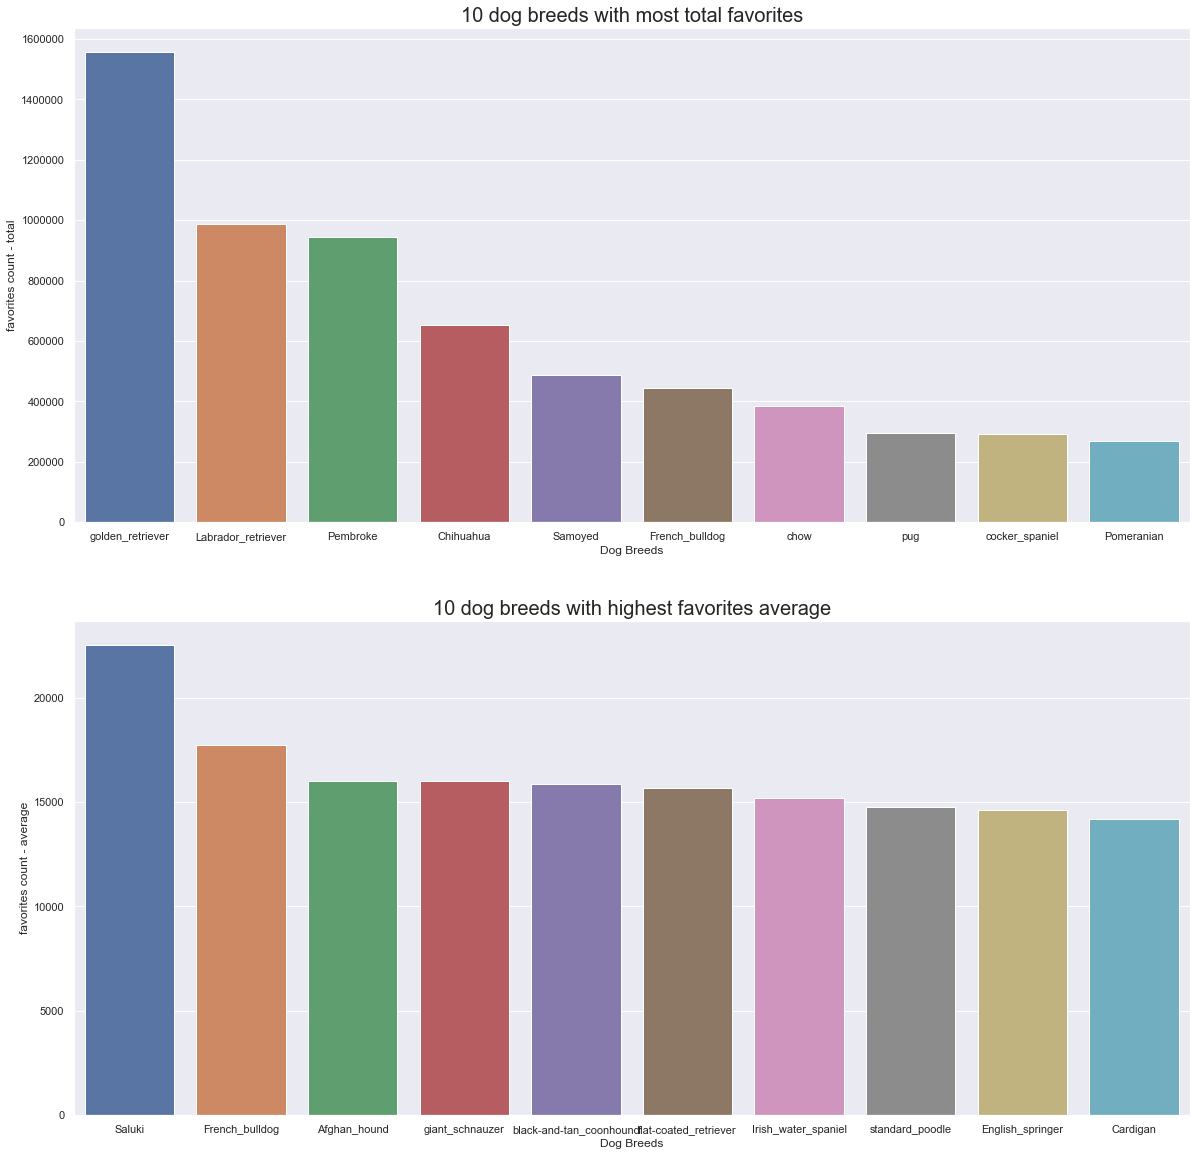

In [50]:
# visualization
fig, ax = plt.subplots(2,1, figsize=(20,20))
sns.barplot(top10_breed_fav_total.p1, top10_breed_fav_total['favorite_count','sum'], label='Top 10 breeds on images', ax=ax[0])
ax[0].set_title('10 dog breeds with most total favorites', fontsize=20)
ax[0].set_xlabel('Dog Breeds')
ax[0].set_ylabel('favorites count - total')
sns.barplot(top10_breed_fav_mean.p1, top10_breed_fav_mean['favorite_count', 'mean'], label='Top 10 breeds on images', ax=ax[1])
ax[1].set_title('10 dog breeds with highest favorites average', fontsize=20)
ax[1].set_xlabel('Dog Breeds')
ax[1].set_ylabel('favorites count - average')
fig.savefig('img/topbreed_fav.jpg')


### 3. Is dog rating correlated with likes?

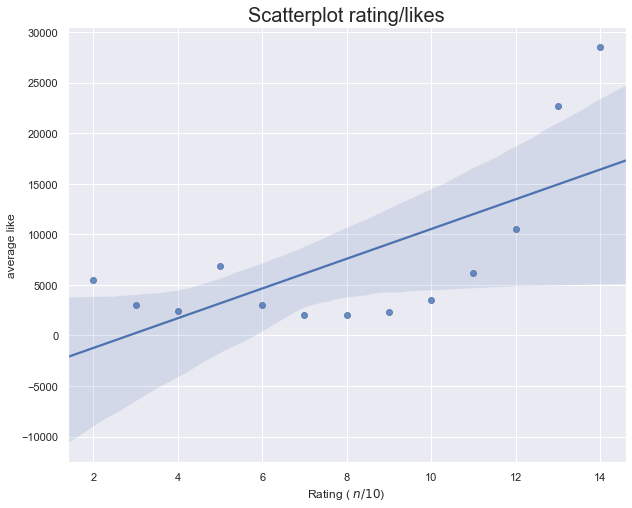

In [51]:
df_rating_fav = df_archive_master[(df_archive_master.p1_dog == True)].groupby('rating_numerator')['favorite_count'].mean().reset_index()
df_rating_fav
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.regplot(x='rating_numerator', y='favorite_count', data=df_rating_fav, ax=ax)
ax.set_title("Scatterplot rating/likes", fontsize=20)
ax.set(xlabel=r'Rating ($\ n / 10$)',ylabel=r"average like")
fig.savefig("img/scatter.jpg")